# Code for the C2S hydrologist technical assessment

My writeup for the technical assessment is here: `JonathanFrame_C2S_technical_challenge.pdf`

Return period analysis was done using this public Matlab code: https://www.mathworks.com/matlabcentral/fileexchange/22628-log-pearson-flood-flow-frequency-using-usgs-17b

Once those return periods were calculated, here is my code for analysis of return periods: `analysis_code_c2s_tulsa_2019.ipynb`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
typez = ['precip_peak_day','precip_cumulative',
         'q_hourly_Haskell', 'q_daily_mean_Haskell','peak_annual_Haskell','peak_annual_Muskogee']
b17_files = {'precip_peak_day':'precip.c.txt', 'q_hourly_Haskell':'qhourly..txt', 
             'q_daily_mean_Haskell':'qdailyme.txt', 'peak_annual_Haskell':'07165570.txt',
             'peak_annual_Muskogee':'07194500.txt', 'precip_cumulative':'precipcu.txt'}

In [3]:

b17={}
for peak_type in typez:
    with open("./b17/out/"+b17_files[peak_type], "r") as f:
        b17[peak_type] = pd.read_csv(f, delimiter="\t", header=None)
        b17[peak_type] = b17[peak_type].rename(columns={0:'RI',1:'E',2:'Y',3:'Y_high',4:'Y_low',5:'d1',6:'d2'})
        b17[peak_type] = b17[peak_type].drop(['d1','d2'], axis=1)

In [4]:
def add_water_year_to_df(df):
    df['datetime'] = pd.to_datetime(df['datetime'])        
    df['year'] = [pd.Timestamp(pd.to_datetime(i)).year for i in df['datetime'].values]
    df['month'] = [pd.Timestamp(pd.to_datetime(i)).month for i in df['datetime'].values]
    df = df.set_index('datetime')
    
    water_year = []
    for m, y in zip(df['month'], df['year']):
        
        if m in [10,11,12]:
            water_year.append(y+1)
        else:
            water_year.append(y)
            
    df['water_year'] = water_year

    df = df.drop(['year', 'month'], axis=1)
    
    return df

In [5]:
with open("river_discharge_daily_mean_1972-2021.txt", 'r') as f:
    q_daily_mean = pd.read_csv(f, delim_whitespace=True, comment='#')
q_daily_mean = q_daily_mean.iloc[1: , :]
q_daily_mean = q_daily_mean.rename(columns={"111158_00060_00003": "cfs", 
                                            "111158_00060_00003_cd": "flag"})
q_daily_mean = add_water_year_to_df(q_daily_mean)

peak_flows_q_daily_mean_Haskell = {int(i):0 for i in list(set(q_daily_mean['water_year']))}
for wy, flow in zip(q_daily_mean['water_year'], q_daily_mean['cfs']):
    if flow == 'Ice':
        continue
    if float(flow) > peak_flows_q_daily_mean_Haskell[int(wy)]:
        peak_flows_q_daily_mean_Haskell[int(wy)] = int(flow)

In [6]:
# WARNING: The timestamp comes in both CDT and CST
# WARNING: The data switches from hourly to 15 minutes at 2009-08-13 09:00 CDT 2009-08-13 11:15 CDT
# WARNING: The hourly discharge data have duplicate dates with conflicting values.
#          duplicate persists, even if accounting for time zone, i.e. 2003-10-26 01:00 
# NOTE:    Keeping the higher of the duplicate values.

with open("river_discharge_hourly_1987-2021.txt", 'r') as f:
    q_hourly = pd.read_csv(f, delimiter='\t', comment='#')

q_hourly = q_hourly.iloc[1: , :]
q_hourly = q_hourly.rename(columns={"112142_00060": "cfs", 
                                    "112142_00060_cd": "flag"})
q_hourly = add_water_year_to_df(q_hourly)
q_hourly.head()

peak_flows_q_hourly_Haskell = {int(i):0 for i in list(set(q_hourly['water_year']))}
for wy, flow in zip(q_hourly['water_year'], q_hourly['cfs']):
    if flow == 'Ice':
        continue
    if float(flow) > peak_flows_q_hourly_Haskell[int(wy)]:
        peak_flows_q_hourly_Haskell[int(wy)] = int(flow)

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
with open("CHIRPS_daily_precip_TulsaOK.csv", 'r') as f:
    daily_precip = pd.read_csv(f)
daily_precip['date'] = pd.DatetimeIndex(pd.to_datetime(daily_precip['date'], format='%Y%m%d'))
daily_precip = daily_precip.rename(columns={"date": "datetime"})
daily_precip = add_water_year_to_df(daily_precip)

peak_daily_precip = {int(i):0 for i in list(set(daily_precip['water_year']))}
for wy, precip in zip(daily_precip['water_year'], daily_precip['precipitation']):
    if float(precip) > peak_daily_precip[int(wy)]:
        peak_daily_precip[wy] = float(precip)
        

In [8]:
lag = 10
peak_lag_precip = {int(i):0 for i in list(set(daily_precip['water_year']))}

peak_cumulative_precip = 0
for i in range(lag, daily_precip.shape[0]):
    
    if daily_precip['water_year'][i-lag] != daily_precip['water_year'][i-lag+1]:
        peak_lag_precip[daily_precip['water_year'][[i-lag]].values[0]] = peak_cumulative_precip
        peak_cumulative_precip = 0
    
    cumulative_precip = daily_precip['precipitation'][i-lag:i].sum()
    
    if cumulative_precip > peak_cumulative_precip:
        peak_cumulative_precip = cumulative_precip


In [9]:
with open('./peaks/07165570_annual_peak.csv', 'r') as f:
    df = pd.read_csv(f, header=None)
df = df.rename({0:'date', 1:'streamflow'}, axis=1)
df['water_year']=0
for i in range(df.shape[0]):
    if int(df.loc[i,'date'].split('-')[1]) in [10, 11, 12]:
        df.loc[i,'water_year'] = int(df.loc[i,'date'].split('-')[0]) + 1
    else:
        df.loc[i,'water_year'] = int(df.loc[i,'date'].split('-')[0])
peak_flows_annual_Haskell = {df.loc[i,'water_year']:df.loc[i,'streamflow'] for i in range(df.shape[0])}

with open('./peaks/07194500_annual_peak.csv', 'r') as f:
    df = pd.read_csv(f, header=None)
df = df.rename({0:'date', 1:'streamflow'}, axis=1)
df['water_year']=0
for i in range(df.shape[0]):
    if int(df.loc[i,'date'].split('-')[1]) in [10, 11, 12]:
        df.loc[i,'water_year'] = int(df.loc[i,'date'].split('-')[0]) + 1
    else:
        df.loc[i,'water_year'] = int(df.loc[i,'date'].split('-')[0])
peak_flows_annual_Muskogee = {df.loc[i,'water_year']:df.loc[i,'streamflow'] for i in range(df.shape[0])}

In [10]:
print('n peak_flows_annual_Haskell', len(list(peak_flows_annual_Haskell.keys())))
print('n peak_flows_annual_Muskogee', len(list(peak_flows_annual_Muskogee.keys())))
print('n peak_flows_q_daily_mean_Haskell', len(list(peak_flows_q_daily_mean_Haskell.keys())))
print('n peak_flows_q_hourly_Haskell', len(list(peak_flows_q_hourly_Haskell.keys())))
print('n peak_daily_precip', len(list(peak_daily_precip.keys())))
print('n peak_lag_precip', len(list(peak_lag_precip.keys())))

n peak_flows_annual_Haskell 48
n peak_flows_annual_Muskogee 63
n peak_flows_q_daily_mean_Haskell 50
n peak_flows_q_hourly_Haskell 34
n peak_daily_precip 41
n peak_lag_precip 41


In [11]:
peak_dict = {'precip_peak_day':peak_daily_precip, 
             'q_hourly_Haskell':peak_flows_q_hourly_Haskell,
             'q_daily_mean_Haskell':peak_flows_q_daily_mean_Haskell,
             'precip_cumulative':peak_lag_precip,
             'peak_annual_Haskell':peak_flows_annual_Haskell,
             'peak_annual_Muskogee':peak_flows_annual_Muskogee}
titlez = {"q_daily_mean_Haskell":"\nDaily streamflow Haskell", 
          "q_hourly_Haskell":"\nHourly streamflow Haskell", 
          "precip_peak_day":"\nPeak daily precitation", 
           "precip_cumulative":"\nCumulative precitation",
          "peak_annual_Haskell":"\nPeak annual Haskell",
          "peak_annual_Muskogee":"\nPeak annual Muskogee"}

In [12]:
def simple_return_period(peak_dict):
    peak_list = [peak_dict[x] for x in list(peak_dict.keys())]
    peak_list.sort(reverse=True)
    peak_ri_list = [(len(peak_list)+1)/(i+1) for i in range(len(peak_list))]
    peak_df = pd.DataFrame({'Y':peak_list,'RI':peak_ri_list})
    return(peak_df)

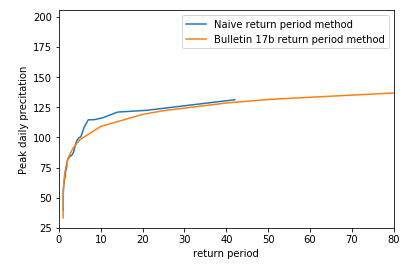

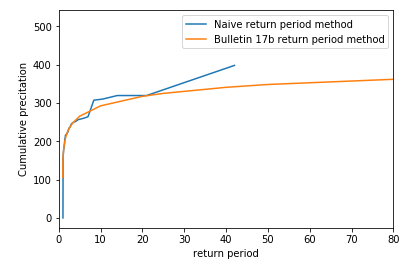

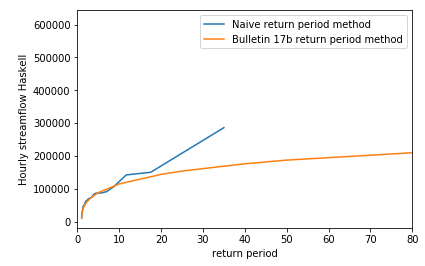

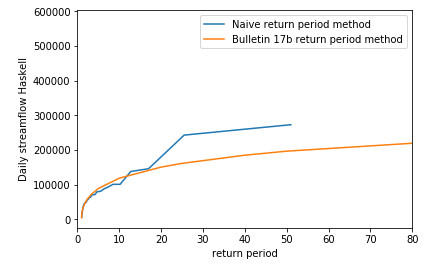

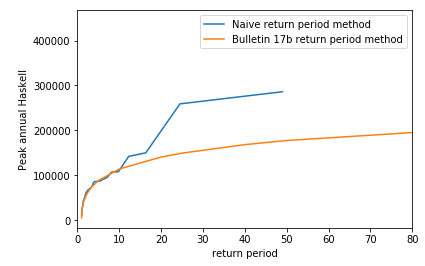

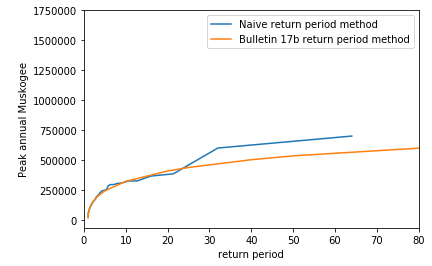

In [13]:
simple_ri = {}
for peak_type in typez:
    simple_ri[peak_type] = simple_return_period(peak_dict[peak_type])

    plt.plot(simple_ri[peak_type]['RI'], simple_ri[peak_type]['Y'], label='Naive return period method')
    plt.plot(b17[peak_type]['RI'], b17[peak_type]['Y'], label='Bulletin 17b return period method')
    plt.xlabel('return period')
    plt.ylabel(titlez[peak_type])
    plt.xlim([0,80])
    plt.legend()
    plt.show()
    plt.close()


In [14]:
for peak_type in typez:
    print('________________________________________')
    print(titlez[peak_type], np.round(peak_dict[peak_type][2019],2))
    for i in range(1, len(list(b17[peak_type]['Y']))):
        if peak_dict[peak_type][2019] > b17[peak_type]['Y'][i-1] and \
           peak_dict[peak_type][2019] <= b17[peak_type]['Y'][i]:
            print(peak_dict[peak_type][2019])
            print('return period is between {:d} and {:d}'.format(int(b17[peak_type]['RI'][i-1]), 
                                                              int(b17[peak_type]['RI'][i])))
            print('Approximately {} years'.format(np.round(b17[peak_type]['RI'][i-1] + \
                                    (peak_dict[peak_type][2019] - b17[peak_type]['Y'][i-1])* \
                                    ((b17[peak_type]['RI'][i] - b17[peak_type]['RI'][i-1]) / \
                                    (b17[peak_type]['Y'][i] - b17[peak_type]['Y'][i-1])),2)))

    print('\nBut, with a simple, naive, estimate')
    
    print(titlez[peak_type], np.round(peak_dict[peak_type][2019],2))
    for i in range(1, len(list(simple_ri[peak_type]['Y']))):

        if peak_dict[peak_type][2019] == simple_ri[peak_type]['Y'].iloc[i]:
            print('return period is Approximately {:d}'.format(int(simple_ri[peak_type]['RI'].iloc[i])))
        
        elif peak_dict[peak_type][2019] < simple_ri[peak_type]['Y'].iloc[i-1] and \
           peak_dict[peak_type][2019] >= simple_ri[peak_type]['Y'].iloc[i]:
 
            print('return period is between {:d} and {:d}'.format(int(simple_ri[peak_type]['RI'].iloc[i-1]), 
                                                              int(simple_ri[peak_type]['RI'].iloc[i])))
            print('Approximately {} years'.format(np.round(simple_ri[peak_type]['RI'].iloc[i-1] + \
                                    (peak_dict[peak_type][2019] - simple_ri[peak_type]['Y'].iloc[i-1])* \
                                    ((simple_ri[peak_type]['RI'].iloc[i] - simple_ri[peak_type]['RI'].iloc[i-1]) / \
                                    (simple_ri[peak_type]['Y'].iloc[i] - simple_ri[peak_type]['Y'].iloc[i-1])),2)))
        
        elif i == len(list(simple_ri[peak_type]['Y']))-1 and \
            peak_dict[peak_type][2019] >= simple_ri[peak_type]['Y'].iloc[0]:
            print('return period is Approximately {:d}'.format(int(simple_ri[peak_type]['RI'].iloc[0])))

________________________________________

Peak daily precitation 78.68
78.68403625488281
return period is between 1 and 2
Approximately 1.89 years

But, with a simple, naive, estimate

Peak daily precitation 78.68
return period is Approximately 1
________________________________________

Cumulative precitation 257.88
257.88088830312097
return period is between 3 and 5
Approximately 4.32 years

But, with a simple, naive, estimate

Cumulative precitation 257.88
return period is Approximately 5
________________________________________

Hourly streamflow Haskell 286000
286000
return period is between 200 and 500
Approximately 293.83 years

But, with a simple, naive, estimate

Hourly streamflow Haskell 286000
return period is Approximately 35
________________________________________

Daily streamflow Haskell 273000
273000
return period is between 100 and 200
Approximately 193.14 years

But, with a simple, naive, estimate

Daily streamflow Haskell 273000
return period is Approximately 51
___